<a href="https://colab.research.google.com/github/thetrotfreak/MCA572/blob/main/2347111_NNDL_Lab6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Data Preprocessing:

In [14]:
import kagglehub
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler

path = kagglehub.dataset_download("tarunpaparaju/apple-aapl-historical-stock-data")
# Load the dataset
# Skip the existing header row and provide column names
data = pd.read_csv(Path(path).joinpath('HistoricalQuotes.csv'), skiprows=1, header=None, names=['Date', 'Close', 'Volume', 'Open', 'High', 'Low'])

# Sort the data by date in ascending order
data = data[::-1].reset_index(drop=True)

# Focus on the 'Close' price column and remove the '$' sign
data['Close'] = data['Close'].str.replace('$', '').astype(float)

# Convert 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

# Split the dataset
training_data_len = int(np.ceil(len(scaled_data) * 0.8))

train_data = scaled_data[:training_data_len]
train_dates = data['Date'][:training_data_len]

sequence_length = 60

test_data = scaled_data[training_data_len - sequence_length:]
test_dates = data['Date'][training_data_len - sequence_length:]
train_data = scaled_data[:training_data_len]
test_data = scaled_data[training_data_len - 60:]  # Include the last 60 for sequence


In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2. Create Training Sequences:

In [16]:
# Function to create sequences
def create_sequences(data, dates, seq_length):
    X = []
    y = []
    y_dates = []
    for i in range(seq_length, len(data)):
        X.append(data[i - seq_length:i, 0])
        y.append(data[i, 0])
        y_dates.append(dates.iloc[i])
    return np.array(X), np.array(y), y_dates

sequence_length = 60
# Create test sequences
X_test, y_test, y_test_dates = create_sequences(test_data, test_dates, sequence_length)

# Reshape data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

X_train, y_train, y_train_dates = create_sequences(train_data, train_dates, sequence_length)

# Reshape data
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

## 3. Build the RNN Model:

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input

# Build the RNN model
model = Sequential()
model.add(Input(shape=(X_train.shape[1], 1)))
model.add(SimpleRNN(50, activation='tanh'))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

## 4. Train the Model:

In [18]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0144 - val_loss: 0.0025
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.1616e-04 - val_loss: 0.0013
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.5521e-04 - val_loss: 0.0014
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.4312e-04 - val_loss: 7.2890e-04
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.2651e-04 - val_loss: 7.5849e-04
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.1931e-04 - val_loss: 5.7039e-04
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 9.9832e-05 - val_loss: 6.6703e-04
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 9.5124e-05 - val_loss: 4.1357e-04
Epoch 9/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 9.3148e-05 - val_loss: 5.4974e-04
Epoch 10/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 8.3606e-05 - val_loss: 2.8309e-04
Epoch 11/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 8.4767e-05 - val_loss: 4.

## 5. Make Predictions:

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


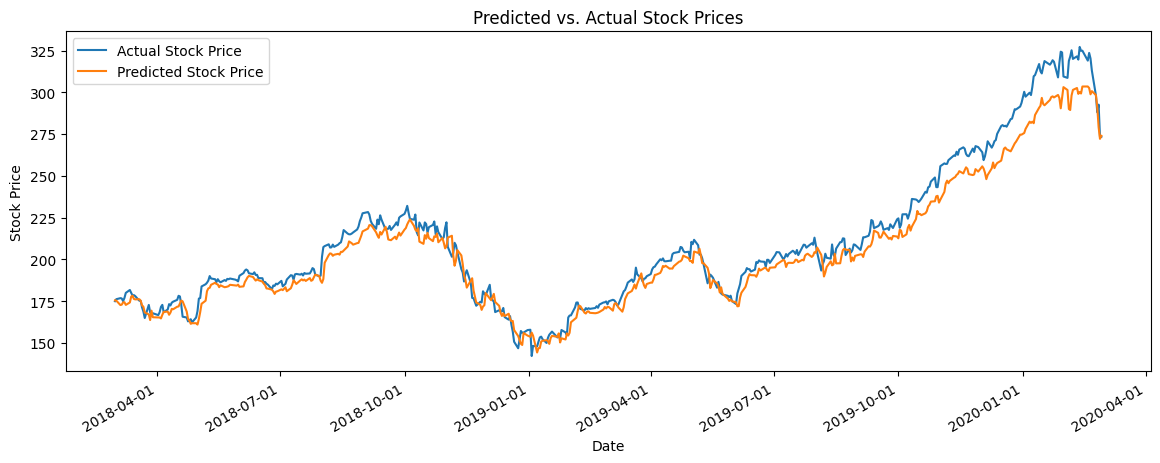

In [19]:
import matplotlib.dates as mdates

# Create test sequences
X_test, y_test,  y_test_dates = create_sequences(test_data,test_dates, sequence_length)

# Reshape data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Make predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# Get actual stock prices
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

# Ensure dates are in datetime format
y_test_dates = pd.to_datetime(y_test_dates)

plt.figure(figsize=(14, 5))
plt.plot(y_test_dates, actual_prices, label='Actual Stock Price')
plt.plot(y_test_dates, predictions, label='Predicted Stock Price')
plt.title('Predicted vs. Actual Stock Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()

# Format the x-axis dates
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())  # Auto-adjust date intervals
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Set date format
plt.gcf().autofmt_xdate()  # Auto-format date labels

plt.show()

## 6. Evaluation:

In [20]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate evaluation metrics
mae = mean_absolute_error(actual_prices, predictions)
rmse = np.sqrt(mean_squared_error(actual_prices, predictions))

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

Mean Absolute Error (MAE): 7.208779680316538
Root Mean Squared Error (RMSE): 9.326248813880694


## Report

> Stock Price Prediction Report

- The Apple stock price prediction model, built with an RNN effectively tracks general price trends, achieving $MAE=7.2$ and $RMSE=9.3$.
- These metrics suggest reliable short-term predictions, with the model’s predictions closely aligning with actual prices in stable periods.

> Observed Limitations

However, limitations are evident:
- The model relies solely on "Close" prices, missing other influential factors like trading volume or economic indicators, which could enhance accuracy.
- Additionally, during high-volatility periods, the model lags slightly behind actual prices, likely due to the limitations of the SimpleRNN architecture.

> Conclusion

Overall, while effective, the model could be improved by incorporating more features and using advanced RNN architectures to better handle market fluctuations.